In [79]:
import os, shutil
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.Session(config=config)

base_dir = 'D:\src\captchagen\out'
rerun_0 = 0
rerun_1 = 1

IMAGE_HEIGHT = 60
IMAGE_WIDTH = 180
MAX_NUM_LEN = 10000

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

def convert2gray(img):
    if len(img.shape) > 2:
        gray = np.mean(img, -1)
        return gray
    else:
        return img
    

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np

MAXLABEL = 40
def num2vec(num):
    if num < 0 or num > 9999 :
        raise ValueError('number not in range 0-9999')
    vector = np.zeros(MAXLABEL)
    i = 0
    while int(num) > 0:
        idx = i * 10 + int(num) % 10
        #print(idx)
        num /= 10
        i += 1
        vector[idx] = 1 
    return vector

train_num = 10000

train_set = np.ndarray(shape=(train_num, IMAGE_HEIGHT, IMAGE_WIDTH),dtype=np.float32)
train_label = np.ndarray(shape=(train_num, MAXLABEL),dtype=np.float32)

for i in range(train_num) :
    fname = '{}.png'.format(i)
    file = os.path.join(train_dir,fname)
    img = image.load_img(file, target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = np.asarray(img,dtype="float32")/255.0
    arr = convert2gray(arr)
    train_set[i] = arr    
    train_label[i] = num2vec(i)

val_num = 10000
val_set = np.ndarray(shape=(val_num, IMAGE_HEIGHT, IMAGE_WIDTH),dtype=np.float32)
val_label = np.ndarray(shape=(val_num, MAXLABEL),dtype=np.float32)

for i in range(val_num) :
    fname = '{}.png'.format(i)
    file = os.path.join(validation_dir,fname)
    img = image.load_img(file, target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = np.asarray(img,dtype="float32")/255.0
    arr = convert2gray(arr)
    val_set[i] = arr    
    val_label[i] = num2vec(i)


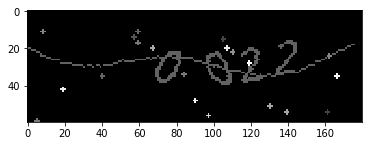

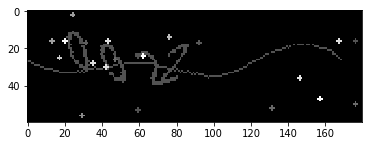

In [81]:
plt.figure(1)
imgplot = plt.imshow(image.array_to_img(val_set[22].reshape(IMAGE_HEIGHT,IMAGE_WIDTH,1)))
plt.figure(2)
imgplot = plt.imshow(image.array_to_img(train_set[22].reshape(IMAGE_HEIGHT,IMAGE_WIDTH,1)))

In [56]:
val_set.shape
val_label.shape

(10000, 40)

In [82]:
train_set = train_set.reshape((train_num,IMAGE_HEIGHT, IMAGE_WIDTH,1))
val_set = val_set.reshape((val_num,IMAGE_HEIGHT, IMAGE_WIDTH,1))

train_set.shape

(10000, 60, 180, 1)

In [84]:
from keras import layers
from keras import models
from keras.models import load_model
from keras import optimizers
from keras import metrics
#from keras.applications import VGG16

#conv_base = VGG16(weights='imagenet',
#                 include_top=False,
#                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,3))

#conv_base.summary()

model = models.Sequential()
model.add(layers.Conv2D(64,(3,3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH,1)))
#model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
#model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Conv2D(256,(3,3), activation='relu'))
model.add(layers.Conv2D(256,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#conv_base.trainable = False
#model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense (64, activation = 'relu'))
model.add(layers.Dense (40, activation = 'sigmoid'))


model.compile(optimizer= 'adadelta',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 58, 178, 64)       640       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 29, 89, 64)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 27, 87, 128)       73856     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 13, 43, 128)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 11, 41, 256)       295168    
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 5, 20, 256)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 3, 18, 512)        1180160   
__________

In [85]:
from keras.callbacks import ModelCheckpoint
#model = load_model('weights-improvement-72-0.60.hdf5')

filepath="D:\src\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#Continue training
history = model.fit(train_set,train_label,epochs=10000,batch_size=32, callbacks=callbacks_list, validation_data=(val_set,val_label))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10000
10000/10000 [==============================] - 18s 2ms/step - loss: 14.2745 - acc: 0.0172 - val_loss: 14.2578 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to D:\src\weights-improvement-01-0.00.hdf5
Epoch 2/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 14.2544 - acc: 0.0267 - val_loss: 14.2504 - val_acc: 0.1000

Epoch 00002: val_acc improved from 0.00000 to 0.10000, saving model to D:\src\weights-improvement-02-0.10.hdf5
Epoch 3/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 14.2514 - acc: 0.0302 - val_loss: 14.2479 - val_acc: 1.0000e-03

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 14.2455 - acc: 0.0265 - val_loss: 14.2324 - val_acc: 0.0223

Epoch 00004: val_acc did not improve from 0.10000
Epoch 5/10000
10000/10000 [========================

10000/10000 [==============================] - 16s 2ms/step - loss: 5.4149 - acc: 0.4665 - val_loss: 5.7265 - val_acc: 0.5188

Epoch 00040: val_acc did not improve from 0.52090
Epoch 41/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4045 - acc: 0.4719 - val_loss: 5.8133 - val_acc: 0.5098

Epoch 00041: val_acc did not improve from 0.52090
Epoch 42/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4144 - acc: 0.4766 - val_loss: 5.6713 - val_acc: 0.5430

Epoch 00042: val_acc improved from 0.52090 to 0.54300, saving model to D:\src\weights-improvement-42-0.54.hdf5
Epoch 43/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4074 - acc: 0.4723 - val_loss: 5.6470 - val_acc: 0.4755

Epoch 00043: val_acc did not improve from 0.54300
Epoch 44/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4108 - acc: 0.4575 - val_loss: 5.7722 - val_acc: 0.4370

Epoch 00044: val_acc did not improve from 0.

10000/10000 [==============================] - 16s 2ms/step - loss: 5.4024 - acc: 0.5906 - val_loss: 5.6944 - val_acc: 0.6064

Epoch 00082: val_acc did not improve from 0.66440
Epoch 83/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4064 - acc: 0.5914 - val_loss: 5.6461 - val_acc: 0.6705

Epoch 00083: val_acc improved from 0.66440 to 0.67050, saving model to D:\src\weights-improvement-83-0.67.hdf5
Epoch 84/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.3932 - acc: 0.6292 - val_loss: 6.0218 - val_acc: 0.5458

Epoch 00084: val_acc did not improve from 0.67050
Epoch 85/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4090 - acc: 0.6012 - val_loss: 5.6991 - val_acc: 0.5560

Epoch 00085: val_acc did not improve from 0.67050
Epoch 86/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.3916 - acc: 0.5948 - val_loss: 5.6536 - val_acc: 0.6267

Epoch 00086: val_acc did not improve from 0.

10000/10000 [==============================] - 16s 2ms/step - loss: 5.3987 - acc: 0.7554 - val_loss: 5.8184 - val_acc: 0.7504

Epoch 00123: val_acc did not improve from 0.82610
Epoch 124/10000
10000/10000 [==============================] - 17s 2ms/step - loss: 5.3933 - acc: 0.7842 - val_loss: 5.8068 - val_acc: 0.8142

Epoch 00124: val_acc did not improve from 0.82610
Epoch 125/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4049 - acc: 0.7755 - val_loss: 5.6944 - val_acc: 0.7029

Epoch 00125: val_acc did not improve from 0.82610
Epoch 126/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4108 - acc: 0.7805 - val_loss: 5.6829 - val_acc: 0.8338

Epoch 00126: val_acc improved from 0.82610 to 0.83380, saving model to D:\src\weights-improvement-126-0.83.hdf5
Epoch 127/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4109 - acc: 0.7749 - val_loss: 5.7555 - val_acc: 0.8336

Epoch 00127: val_acc did not improve fr

10000/10000 [==============================] - 16s 2ms/step - loss: 5.4290 - acc: 0.8694 - val_loss: 5.8265 - val_acc: 0.8813

Epoch 00164: val_acc improved from 0.87840 to 0.88130, saving model to D:\src\weights-improvement-164-0.88.hdf5
Epoch 165/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4128 - acc: 0.8878 - val_loss: 5.8517 - val_acc: 0.8713

Epoch 00165: val_acc did not improve from 0.88130
Epoch 166/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4235 - acc: 0.8687 - val_loss: 5.8471 - val_acc: 0.8186

Epoch 00166: val_acc did not improve from 0.88130
Epoch 167/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4276 - acc: 0.8797 - val_loss: 6.0428 - val_acc: 0.8539

Epoch 00167: val_acc did not improve from 0.88130
Epoch 168/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.4316 - acc: 0.8925 - val_loss: 5.8079 - val_acc: 0.8551

Epoch 00168: val_acc did not improve fr

10000/10000 [==============================] - 16s 2ms/step - loss: 5.5089 - acc: 0.9410 - val_loss: 5.8902 - val_acc: 0.9610

Epoch 00205: val_acc improved from 0.93600 to 0.96100, saving model to D:\src\weights-improvement-205-0.96.hdf5
Epoch 206/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.5105 - acc: 0.9431 - val_loss: 6.1643 - val_acc: 0.9192

Epoch 00206: val_acc did not improve from 0.96100
Epoch 207/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.5382 - acc: 0.9433 - val_loss: 6.1516 - val_acc: 0.9150

Epoch 00207: val_acc did not improve from 0.96100
Epoch 208/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.5048 - acc: 0.9353 - val_loss: 6.0631 - val_acc: 0.9232

Epoch 00208: val_acc did not improve from 0.96100
Epoch 209/10000
10000/10000 [==============================] - 16s 2ms/step - loss: 5.5265 - acc: 0.9419 - val_loss: 5.9849 - val_acc: 0.9325

Epoch 00209: val_acc did not improve fr

KeyboardInterrupt: 

In [132]:
test_dir = os.path.join(base_dir, 'test')
test_set = np.ndarray(shape=(train_num, IMAGE_HEIGHT, IMAGE_WIDTH),dtype=np.float32)
test_label = np.ndarray(shape=(train_num, MAXLABEL),dtype=np.float32)
test_num = 10000
for i in range(test_num) :
    fname = '{}.png'.format(i)
    file = os.path.join(test_dir,fname)
    img = image.load_img(file, target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    arr = np.asarray(img,dtype="float32")/255.0
    arr = convert2gray(arr)
    test_set[i] = arr    
    test_label[i] = num2vec(i)

test_set = test_set.reshape((test_num,IMAGE_HEIGHT, IMAGE_WIDTH,1))
real_label = model.predict(test_set)

In [161]:
alabel = real_label[4535].reshape(4,10)
alabel.argmax(axis=1)

array([5, 3, 5, 4], dtype=int64)